In [1]:
import geopandas as gpd
import pickle
from sklearn.neighbors import BallTree
import numpy as np
from shapely.geometry import LineString
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import compress

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
def load_obj(name ):
    with open(root_path + 'WorkingData/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
Mapset = load_obj("Clipped5k_Euston")

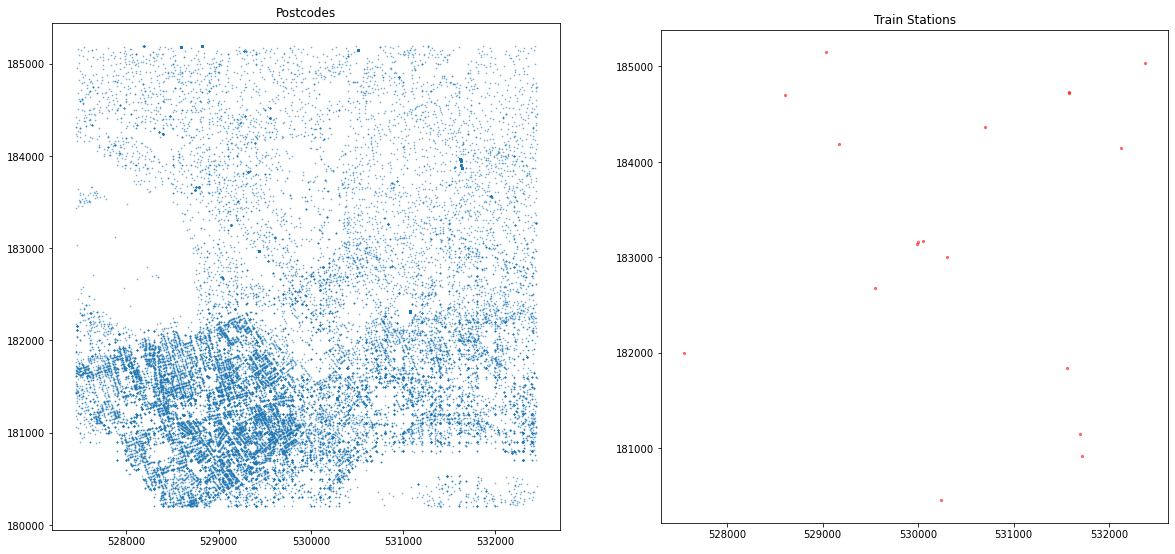

In [4]:
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))
#Plot postcodes
Mapset['NSPL_gdf'].plot(ax=axes[0],markersize=0.5, alpha=0.5)
axes[0].set_title('Postcodes')

#Plot Train Stations
Mapset['RailwayStations'].plot(ax=axes[1], markersize=5, alpha=0.5, color='red')
axes[1].set_title('Train Stations');

In [5]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
     # removed metric since the default is euclidian (what my coordinates use)
    tree = BallTree(candidates, leaf_size=15)

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [6]:
def nearest_neighbor(left_gdf, right_gdf, right_col_name, outname, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    """
    
    #Some of the data frames will have empty geometries so this will drop them
    left_gdf = left_gdf[~(left_gdf.is_empty)]
    right_gdf = right_gdf[~(right_gdf.is_empty)]
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    left = left_gdf.copy().reset_index(drop=True)
    right = right_gdf.copy().reset_index(drop=True)
    
    left_points = np.array(left[left_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())
    right_points = np.array(right[right_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_points, candidates=right_points)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    left_index = left_gdf.index
    closest_points = closest_points.reset_index(drop=True)
    closest_points = closest_points.set_index(left_index)
    
    #Select the columns to keep in the output dataframe
    keep = [right_col_name, 'geometry']
    closest_points = closest_points[keep]
    
    suffix = "Nearest_" + outname
    
    closest_points = closest_points.rename(columns={right_col_name: suffix + '_Name'})
    closest_points = closest_points.rename(columns={'geometry': suffix + '_Geometry'})
    
    # Add distance if requested
    if return_dist:
        closest_points[suffix + '_Distance'] = dist

    return closest_points

In [7]:
Nearest_TrainStation = nearest_neighbor(Mapset['NSPL_gdf'], 
                                        Mapset['RailwayStations'], 
                                        "StationName", 
                                        "TrainStation", 
                                        return_dist=True)

# And the result looks like ..
Nearest_TrainStation

Nearest_TrainStation_Name  Nearest_TrainStation_Geometry  \
480363     London Kings Cross Rail Station  POINT (530300.000 183000.000)   
757939    Farringdon (London) Rail Station  POINT (531560.000 181840.000)   
757940        City Thameslink Rail Station  POINT (531690.000 181150.000)   
757941    Farringdon (London) Rail Station  POINT (531560.000 181840.000)   
757942    Farringdon (London) Rail Station  POINT (531560.000 181840.000)   
...                                    ...                            ...   
2531230  London Charing Cross Rail Station  POINT (530235.000 180455.000)   
2531231  London Charing Cross Rail Station  POINT (530235.000 180455.000)   
2531232   Farringdon (London) Rail Station  POINT (531560.000 181840.000)   
2531234  London Charing Cross Rail Station  POINT (530235.000 180455.000)   
2531235  London Charing Cross Rail Station  POINT (530235.000 180455.000)   

         Nearest_TrainStation_Distance  
480363                      516.364213  
757939                      691.234403  
757940                      344.383507  
757941                      681.687612  
757942                      590.931468  
...                                ...  
2531230                     926.244568  
2531231                     926.244568  
2531232                     681.687612  
2531234                     926.244568  
2531235                     405.744994  

[44486 rows x 3 columns]

In [8]:
# Merge the datasets by index (for this, it is good to use '.join()' -function)
Mapset['NSPL_gdf'] = Mapset['NSPL_gdf'].join(Nearest_TrainStation)

C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


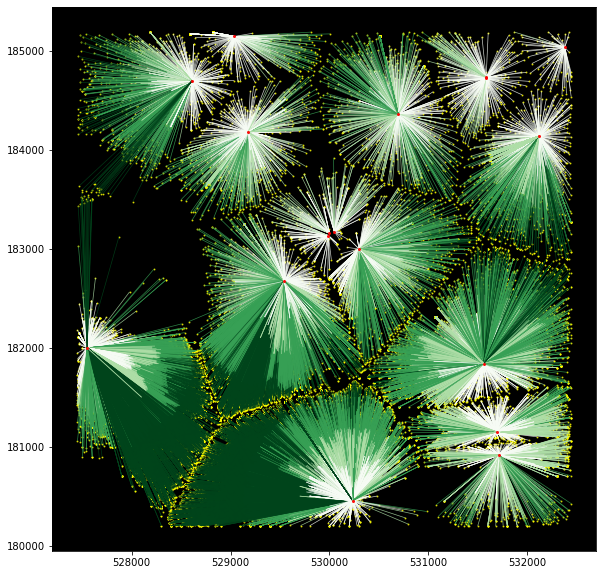

In [9]:
# Create a link (LineString) between building and stop points
Mapset['NSPL_gdf']['link'] = Mapset['NSPL_gdf'].apply(lambda row: LineString([row['geometry'], row['Nearest_TrainStation_Geometry']]), axis=1)

# Set link as the active geometry
Postcode_links = Mapset['NSPL_gdf'].copy()
Postcode_links = Postcode_links.set_geometry('link')

# Plot the connecting links between buildings and stops and color them based on distance
ax = Postcode_links.plot(column='Nearest_TrainStation_Distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 10))
ax = Mapset['NSPL_gdf'].plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = Mapset['RailwayStations'].plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')

plt.savefig("Images/" + 'NearestNeighbour.png',dpi=300)

Now lets try on the whole country

In [10]:
All_Maps = load_obj("All_Maps")

In [11]:
All_Maps['NSPL_gdf'] = All_Maps['NSPL_gdf'][~All_Maps['NSPL_gdf']['geometry'].is_empty]

In [12]:
Nearest_TrainStation = nearest_neighbor(All_Maps['NSPL_gdf'], 
                                        All_Maps['RailwayStations'], 
                                        "StationName", 
                                        "TrainStation", 
                                        return_dist=True)

In [14]:
All_Maps['NSPL_gdf'] = All_Maps['NSPL_gdf'].join(Nearest_TrainStation)

In [49]:
def plot_nearest_neighbour(mapset, left_name, right_name, nearest_item_name, figsize=(15,15), save=False, savename=""):
    
    left_gdf = mapset[left_name]
    right_gdf = mapset[right_name]
    
    nm = 'Nearest_'+nearest_item_name
    
    # Create a link (LineString) between building and stop points
    left_gdf['link'] = left_gdf.apply(lambda row: LineString([row['geometry'], row[nm+'_Geometry']]), axis=1)

    # Set link as the active geometry
    Postcode_links = left_gdf.copy()
    Postcode_links = Postcode_links.set_geometry('link')

    fig, ax = plt.subplots(1, figsize=figsize)

    # Set map background color to black, which helps with contrast
    ax.set_facecolor('black')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Plot the connecting links between buildings and stops and color them based on distance
    Postcode_links.plot(ax=ax, column=nm+'_Distance', cmap='Greens', scheme='quantiles', alpha=0.8, lw=0.5, zorder=1)
    left_gdf.plot(ax=ax, color='yellow', markersize=0.5, alpha=0.5, zorder=2)
    right_gdf.plot(ax=ax, markersize=5, marker='o', color='red', alpha=1, zorder=3)
    
    if save:
        plt.savefig("Images/" + savename + "_" + 'nearest_item_name.png',dpi=300)


C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


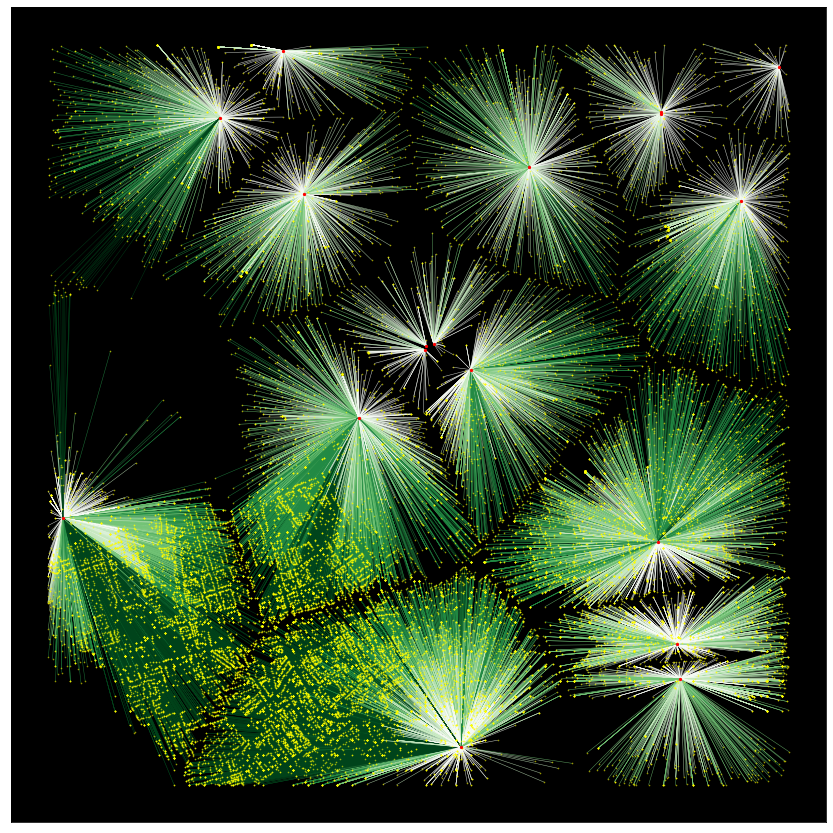

In [50]:
plot_nearest_neighbour(Mapset,
                       'NSPL_gdf', 
                       'RailwayStations', 
                       'TrainStation', 
                       figsize=(15,15), 
                       save=True,
                       savename="Euston")

C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


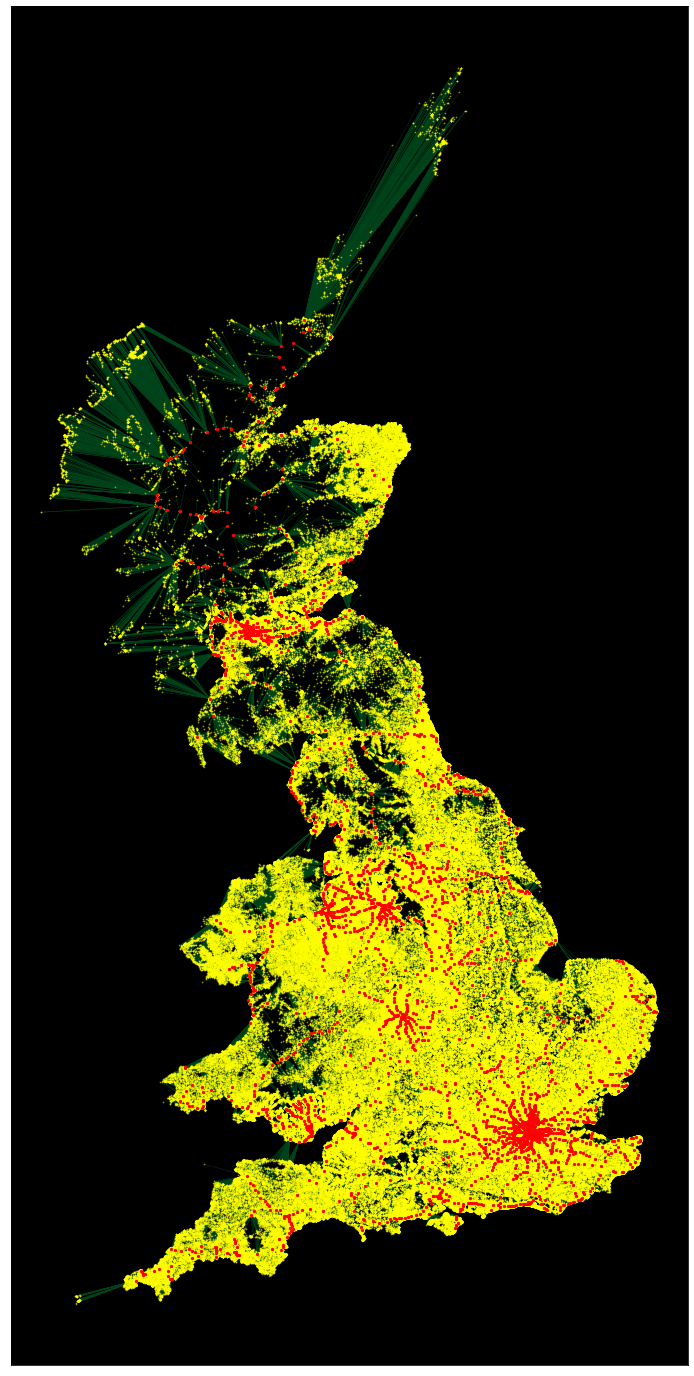

In [51]:
plot_nearest_neighbour(All_Maps,
                       'NSPL_gdf', 
                       'RailwayStations', 
                       'TrainStation', 
                       figsize=(15,25), 
                       save=True,
                       savename="AllUK")

Modify nearest_neighbor() and get_nearest_point() so that it merges on the new columns to the source dataset

In [54]:
def get_nearest_point(src_points, #Source gdf, the gdf with the points you want to attach distances to
                      candidates, #gdf containing the list of points you want to get the distances to
                      k_neighbors=1 #Return just the closest point
                     ):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
     # removed metric since the default is euclidian (what my coordinates use)
    tree = BallTree(candidates, leaf_size=15)

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [190]:
def nearest_neighbor_point(left_gdf, #source data
                         right_gdf, #points data
                         right_col_name, #in the points data, what column contains the name of the points
                         outname, #in the output data what do you want to refer to the points as
                         keep_n_g_d = [True, True, True], #do you want to keep the geometry, point name and distance
                         merge=False #Make a new output or merge onto left_gdf
                        ):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    """
    
    suffix = "Nearest_" + outname
    
    if len(right_gdf)>0:
        #Some of the data frames will have empty geometries so this will drop them
        left_gdf = left_gdf[~(left_gdf.is_empty)]
        right_gdf = right_gdf[~(right_gdf.is_empty)]

        left_geom_col = left_gdf.geometry.name
        right_geom_col = right_gdf.geometry.name

        # Ensure that index in right gdf is formed of sequential numbers
        left = left_gdf.copy().reset_index(drop=True)
        right = right_gdf.copy().reset_index(drop=True)

        left_points = np.array(left[left_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())
        right_points = np.array(right[right_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())

        # Find the nearest points
        # -----------------------
        # closest ==> index in right_gdf that corresponds to the closest point
        # dist ==> distance between the nearest neighbors (in meters)

        closest, dist = get_nearest_point(src_points=left_points, candidates=right_points)

        # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
        closest_points = right.loc[closest]

        # Ensure that the index corresponds the one in left_gdf
        left_index = left_gdf.index
        closest_points = closest_points.reset_index(drop=True)
        closest_points = closest_points.set_index(left_index)

        #Select the columns to keep in the output dataframe
        keep = [right_col_name, 'geometry']  
        closest_points = closest_points[keep]

        #Rename the columns to keep
        closest_points = closest_points.rename(columns={right_col_name: suffix + '_name'})
        closest_points = closest_points.rename(columns={'geometry': suffix + '_geometry'})
        closest_points[suffix + '_Distance'] = dist

        closest_points = closest_points.loc[:,keep_n_g_d]

    else:
        closest_points = left_gdf.iloc[:,0]
        closest_points[suffix + '_name'] = ""
        closest_points = closest_points[suffix + '_name']
        closest_points[suffix + '_geometry'] = ""
        closest_points[suffix + '_Distance'] = np.nan
        #closest_points = closest_points.loc[:,keep_n_g_d]
        
        
    # either add the columns to left_gdf or make a new dataframe
    if merge:
        out = left_gdf.join(closest_points)
    else:
        out = closest_points
    return out

In [152]:
def plot_nearest_neighbour(mapset, left_name, right_name, nearest_item_name, figsize=(15,15), save=False, savename=""):
    
    left_gdf = mapset[left_name]
    right_gdf = mapset[right_name]
    
    nm = 'Nearest_'+nearest_item_name
    
    # Create a link (LineString) between building and stop points
    left_gdf['link'] = left_gdf.apply(lambda row: LineString([row['geometry'], row[nm+'_geometry']]), axis=1)

    # Set link as the active geometry
    Postcode_links = left_gdf.copy()
    Postcode_links = Postcode_links.set_geometry('link')

    fig, ax = plt.subplots(1, figsize=figsize)

    # Set map background color to black, which helps with contrast
    ax.set_facecolor('black')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Plot the connecting links between buildings and stops and color them based on distance
    Postcode_links.plot(ax=ax, column=nm+'_Distance', cmap='Greens', scheme='quantiles', alpha=0.8, lw=0.5, zorder=1)
    left_gdf.plot(ax=ax, color='yellow', markersize=0.5, alpha=0.5, zorder=2)
    right_gdf.plot(ax=ax, markersize=5, marker='o', color='red', alpha=1, zorder=3)
    
    if save:
        plt.savefig("Images/" + savename + "_" + 'nearest_' + nearest_item_name + '.png',dpi=300)

Make a new gdf that we will populate with the postcode data we want

In [191]:
Mapset = load_obj("Clipped5k_Euston")
keep_n_g_d = [False, True, True]
figsize = (15,15)
savename = "Euston"

columns = ["Postcode_NS", "geometry"]
Mapset["Postcode_Distances"] = Mapset["NSPL_gdf"].loc[:,columns]

Get nearest points

In [192]:
#Train Stations
Mapset["Postcode_Distances"] = nearest_neighbor_point(Mapset["Postcode_Distances"],
                                                      Mapset["RailwayStations"],
                                                      "StationName", 
                                                      "TrainStation", 
                                                      keep_n_g_d = keep_n_g_d, 
                                                      merge=True)

#Bus Stops
Mapset["Postcode_Distances"] = nearest_neighbor_point(Mapset["Postcode_Distances"],
                                                      Mapset["BusStops"],
                                                      "CommonName", 
                                                      "BusStop", 
                                                      keep_n_g_d = keep_n_g_d, 
                                                      merge=True)

#Ferry Terminals
Mapset["Postcode_Distances"] = nearest_neighbor_point(Mapset["Postcode_Distances"],
                                                      Mapset["FerryTerminals"],
                                                      "Name", 
                                                      "FerryTerminal", 
                                                      keep_n_g_d = keep_n_g_d, 
                                                      merge=True)

#Motorway Junctions
Mapset["Postcode_Distances"] = nearest_neighbor_point(Mapset["Postcode_Distances"],
                                                      Mapset["MotorwayJunctions"],
                                                      "identifier", 
                                                      "MotorwayJunction", 
                                                      keep_n_g_d = keep_n_g_d, 
                                                      merge=True)

C:\Users\richa\AppData\Local\Temp/ipykernel_19816/2531832396.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closest_points[suffix + '_name'] = ""


TypeError: 'str' object does not support item assignment

In [175]:
Mapset["Postcode_Distances"]



480363     CM233WE
757939     EC1A1AA
757940     EC1A1AE
757941     EC1A1AH
757942     EC1A1AL
            ...   
2531230    WC2R3WY
2531231    WC2R3WZ
2531232    WC2R3XP
2531234    WC990LF
2531235    WC999AP
Name: Postcode_NS, Length: 44486, dtype: object

In [178]:
left_gdf['test'] = np.nan
left_gdf

Postcode_NS                       geometry  \
480363      CM233WE  POINT (530754.000 182754.000)   
757939      EC1A1AA  POINT (531131.000 182382.000)   
757940      EC1A1AE  POINT (532000.000 181300.000)   
757941      EC1A1AH  POINT (531073.000 182317.000)   
757942      EC1A1AL  POINT (532100.000 181600.000)   
...             ...                            ...   
2531230     WC2R3WY  POINT (530283.000 181380.000)   
2531231     WC2R3WZ  POINT (530283.000 181380.000)   
2531232     WC2R3XP  POINT (531073.000 182317.000)   
2531234     WC990LF  POINT (530283.000 181380.000)   
2531235     WC999AP  POINT (530180.000 180857.000)   

         Nearest_TrainStation_geometry  Nearest_TrainStation_Distance  \
480363   POINT (530300.000 183000.000)                     516.364213   
757939   POINT (531560.000 181840.000)                     691.234403   
757940   POINT (531690.000 181150.000)                     344.383507   
757941   POINT (531560.000 181840.000)                     681.687612   
757942   POINT (531560.000 181840.000)                     590.931468   
...                                ...                            ...   
2531230  POINT (530235.000 180455.000)                     926.244568   
2531231  POINT (530235.000 180455.000)                     926.244568   
2531232  POINT (531560.000 181840.000)                     681.687612   
2531234  POINT (530235.000 180455.000)                     926.244568   
2531235  POINT (530235.000 180455.000)                     405.744994   

              Nearest_BusStop_geometry  Nearest_BusStop_Distance  \
480363   POINT (530720.000 182755.000)                 34.014703   
757939   POINT (531127.000 182421.000)                 39.204592   
757940   POINT (532039.000 181306.000)                 39.458839   
757941   POINT (531110.000 182227.000)                 97.308787   
757942   POINT (532127.000 181639.000)                 47.434165   
...                                ...                       ...   
2531230  POINT (530278.000 181384.000)                  6.403124   
2531231  POINT (530278.000 181384.000)                  6.403124   
2531232  POINT (531110.000 182227.000)                 97.308787   
2531234  POINT (530278.000 181384.000)                  6.403124   
2531235  POINT (530030.000 180850.000)                150.163245   

        Nearest_FerryTerminal_geometry  Nearest_FerryTerminal_Distance  test  
480363   POINT (531556.000 180804.000)                     2108.483815   NaN  
757939   POINT (531556.000 180804.000)                     1634.230400   NaN  
757940   POINT (531556.000 180804.000)                      665.696628   NaN  
757941   POINT (531556.000 180804.000)                     1588.224795   NaN  
757942   POINT (531556.000 180804.000)                      964.132771   NaN  
...                                ...                             ...   ...  
2531230  POINT (530570.000 180552.000)                      876.329276   NaN  
2531231  POINT (530570.000 180552.000)                      876.329276   NaN  
2531232  POINT (531556.000 180804.000)                     1588.224795   NaN  
2531234  POINT (530570.000 180552.000)                      876.329276   NaN  
2531235  POINT (530570.000 180552.000)                      495.101000   NaN  

[44486 rows x 9 columns]

C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\richa\Anaconda3\envs\LandReg_py\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


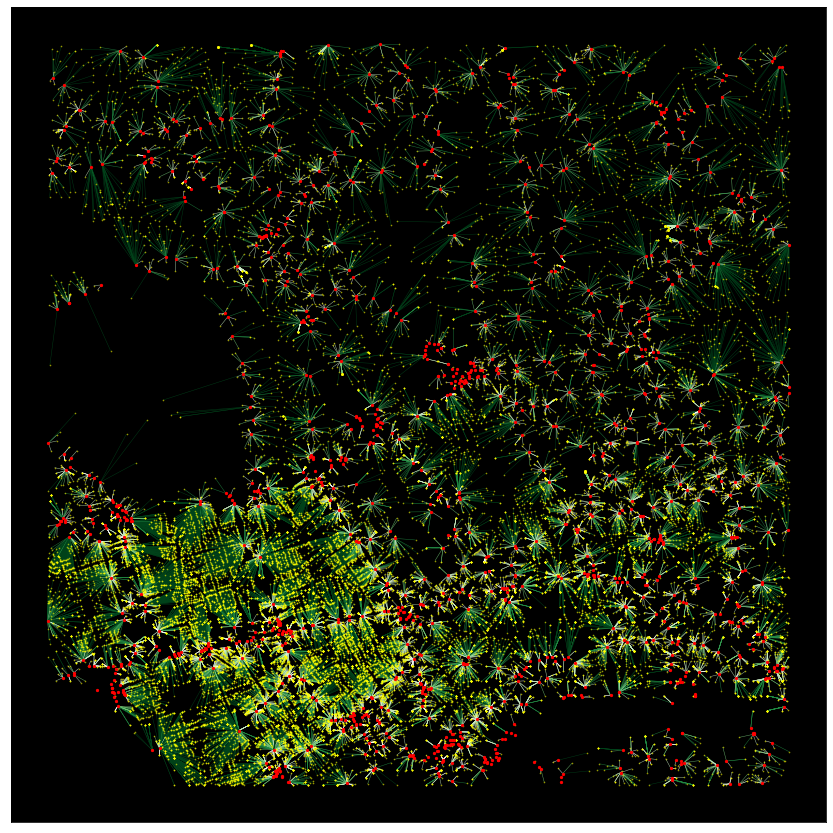

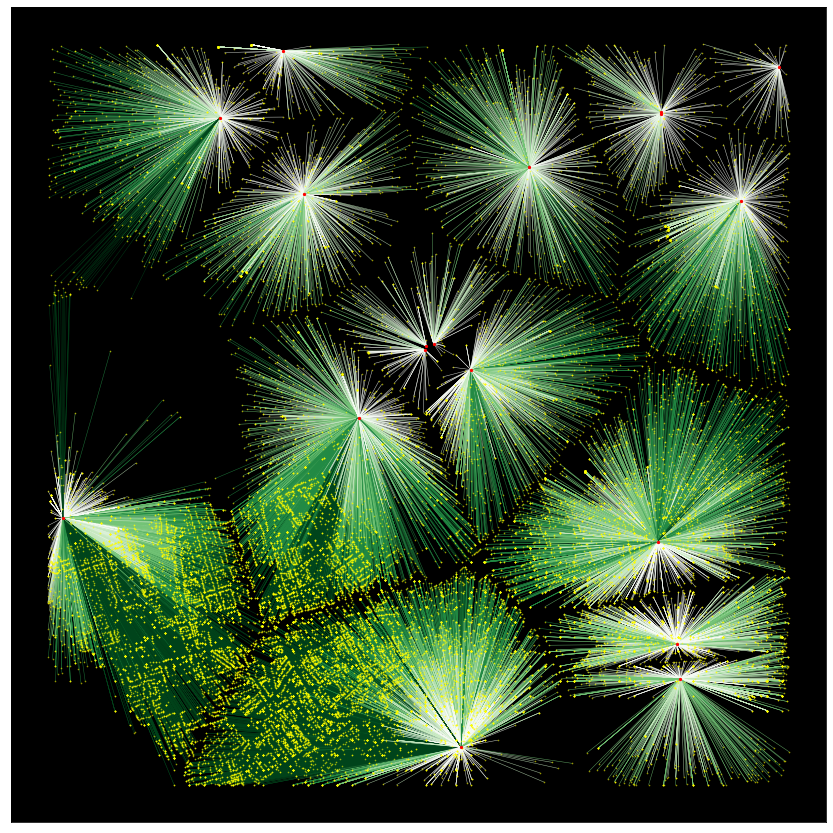

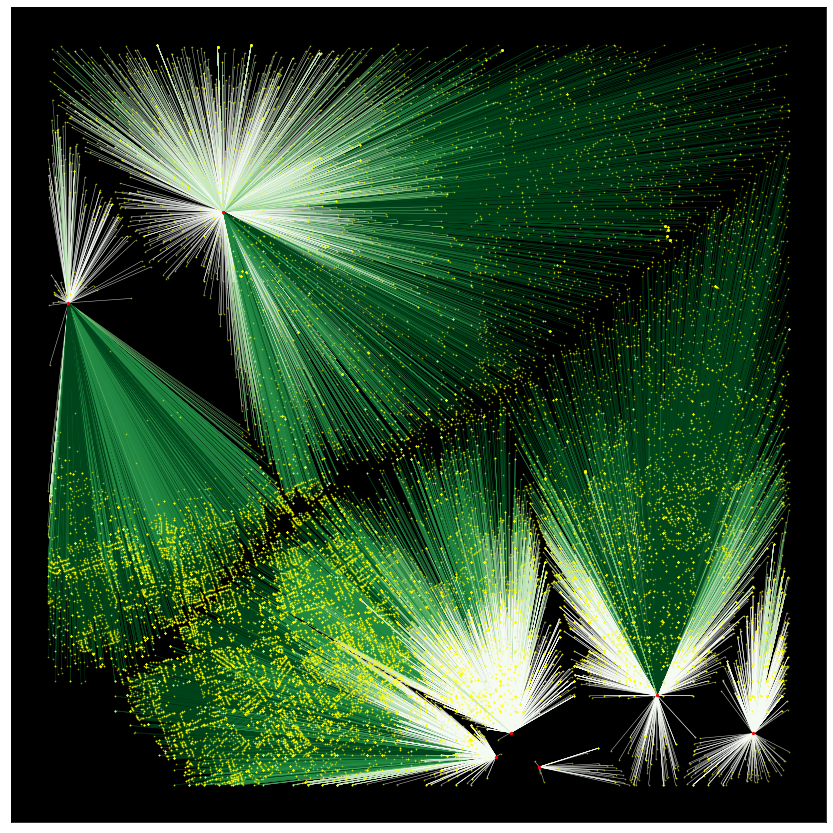

In [158]:
plot_nearest_neighbour(Mapset,
                       left_name='Postcode_Distances', 
                       right_name='BusStops', 
                       nearest_item_name='BusStop', 
                       figsize=figsize, 
                       save=True,
                       savename=savename)

plot_nearest_neighbour(Mapset,
                       left_name='Postcode_Distances', 
                       right_name='RailwayStations', 
                       nearest_item_name='TrainStation', 
                       figsize=figsize, 
                       save=True,
                       savename=savename)

plot_nearest_neighbour(Mapset,
                       left_name='Postcode_Distances', 
                       right_name='FerryTerminals', 
                       nearest_item_name='FerryTerminal', 
                       figsize=figsize, 
                       save=True,
                       savename=savename)